# Low-rank Parareal behavior for stagnation of singular values

The behavior of the low-rank parareal algorithm when the singular values have a stagnation. 
Three cases are studied:

1. The stagnation is around the coarse rank.
2. The stagnation is between the coarse and the fine rank.
3. The stagnation is around the fine rank.

Elsewhere, the singular values are assumed to have an exponential decay until the machine precision is reached.

## 0. Parameters and importations

In [1]:
# IMPORTATIONS
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from low_rank_toolbox import svd
from low_rank_toolbox.low_rank_matrix import LowRankMatrix
from ivps.lyapunov import LyapunovIVP
import classical_solvers
from pint import parareal



# PARAMETERS
t_span = (0, 2)
n = 100
initial_value_rank = 21
stationary_solution_rank = 21
nb_parareal_iter = 50
dlra_meth = 'PERK1'

## 1. Creation of the three problems

In [2]:
# 1D Laplacian as stencil 1/dx^2 [1 -2 1] in csc format
x = np.linspace(-1, 1, num=n)
dx = x[1] - x[0]
ones = np.ones(n)
data = 1 / (dx ** 2) * np.array([ones, -2 * ones, ones])
diags = np.array([-1, 0, 1])
A = sp.sparse.spdiags(data, diags, n, n, format="csc")

### 1.1. Stagnation around coarse rank

In [3]:
# X0 with stagnation
index = int(initial_value_rank/3)
sing_vals1 = np.linspace(1, 1e-1, index) # stagnation is here
sing_vals2 = np.logspace(-2, -8, index) 
sing_vals3 = np.logspace(-9, -15, index)
s0 = np.concatenate([sing_vals1, sing_vals2, sing_vals3])
X0 = svd.generate_low_rank_matrix((n,n), s0, seed=1111)

# C such that stationary solution has stagnation
index = int(stationary_solution_rank/3)
sing_vals1 = np.linspace(1, 1e-1, index) # stagnation is here
sing_vals2 = np.logspace(-2, -8, index) 
sing_vals3 = np.logspace(-9, -15, index)
s = np.concatenate([sing_vals1, sing_vals2, sing_vals3])
X = svd.generate_low_rank_matrix((n,n), s, seed=2222, is_symmetric=True)
C = - X.dot_sparse(A, side='opposite') - X.dot_sparse(A)

# Create a Lyapunov Problem
PB1 = LyapunovIVP(t_span, X0, A, C)

### 1.2. Stagnation in the middle

In [4]:
# X0 with stagnation
index = int(initial_value_rank/3)
sing_vals1 = np.logspace(0, -6, index)
sing_vals2 = np.linspace(1e-7, 1e-8, index)  # stagnation is here
sing_vals3 = np.logspace(-9, -15, index)
s0 = np.concatenate([sing_vals1, sing_vals2, sing_vals3])
X0 = svd.generate_low_rank_matrix((n,n), s0, seed=1111)

# C such that stationary solution has stagnation
index = int(stationary_solution_rank/3)
sing_vals1 = np.logspace(0, -6, index) 
sing_vals2 = np.linspace(1e-7, 1e-8, index) # stagnation is here
sing_vals3 = np.logspace(-9, -15, index)
s = np.concatenate([sing_vals1, sing_vals2, sing_vals3])
X = svd.generate_low_rank_matrix((n,n), s, seed=2222, is_symmetric=True)
C = - X.dot_sparse(A, side='opposite') - X.dot_sparse(A)

# Create a Lyapunov Problem
PB2 = LyapunovIVP(t_span, X0, A, C)

### 1.3. Stagnation around the fine rank

In [5]:
# X0 with stagnation
index = int(initial_value_rank/3)
sing_vals1 = np.logspace(0, -6, index) 
sing_vals2 = np.logspace(-7, -13, index) 
sing_vals3 = np.linspace(1e-14, 1e-15, index) # stagnation is here
s0 = np.concatenate([sing_vals1, sing_vals2, sing_vals3])
X0 = svd.generate_low_rank_matrix((n,n), s0, seed=1111)

# C such that stationary solution has stagnation
index = int(stationary_solution_rank/3)
sing_vals1 = np.logspace(0, -6, index) 
sing_vals2 = np.logspace(-7, -13, index) 
sing_vals3 = np.linspace(1e-14, 1e-15, index) # stagnation is here
s = np.concatenate([sing_vals1, sing_vals2, sing_vals3])
X = svd.generate_low_rank_matrix((n,n), s, seed=2222, is_symmetric=True)
C = - X.dot_sparse(A, side='opposite') - X.dot_sparse(A)

# Create a Lyapunov Problem
PB3 = LyapunovIVP(t_span, X0, A, C)

## 2. Singular values over time

In [6]:
# COMPUTE THE 3 REFERENCE SOLUTIONS
ref_sol1 = classical_solvers.solve(PB1, nb_t_steps=nb_parareal_iter, monitoring=True)
ref_sol2 = classical_solvers.solve(PB2, nb_t_steps=nb_parareal_iter, monitoring=True)
ref_sol3 = classical_solvers.solve(PB3, nb_t_steps=nb_parareal_iter, monitoring=True)

Solving with optimal: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


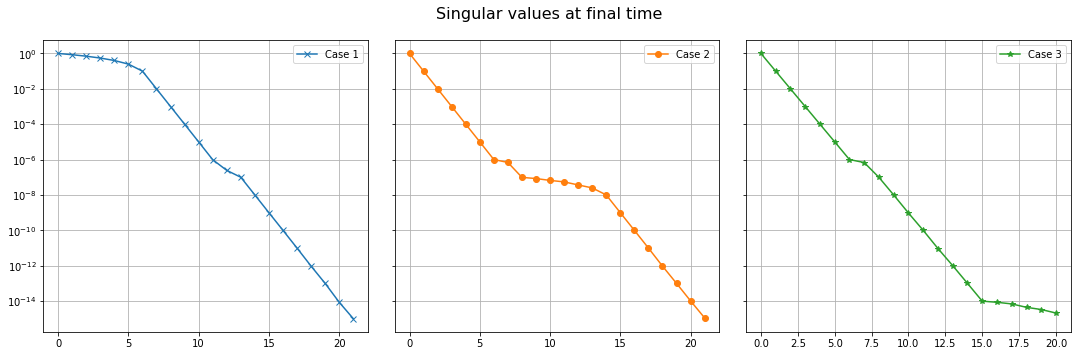

In [7]:
# PLOT THE SINGULAR VALUES AT A GIVEN TIME
time_index = -1

fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
plt.suptitle('Singular values at final time', fontsize=16)
plt.tight_layout()
# SUBPLOT 1
ax[0].semilogy(ref_sol1.Ys[time_index].sing_vals, '-x', color='#1f77b4', label='Case 1')
ax[0].legend()
ax[0].grid()

# SUBPLOT 2
ax[1].semilogy(ref_sol2.Ys[time_index].sing_vals, '-o', color='#ff7f0e', label='Case 2')
ax[1].legend()
ax[1].grid()

# SUBPLOT 3
ax[2].semilogy(ref_sol3.Ys[time_index].sing_vals, '-*', color='#2ca02c', label='Case 3')
ax[2].legend()
ax[2].grid()

plt.show()
fig.savefig(f'figures/Lyapunov_heat/Size{n}/stagnation_singular_values.pdf')

## 3. Low-rank Parareal behaviors

In [8]:
LRP1 = parareal.LowRankParareal(problem = PB1,
                               coarse_rank=4,
                               fine_rank=20,
                               nb_parareal_iter=nb_parareal_iter,
                               nb_coarse_substeps=1,
                               coarse_dlra_method=dlra_meth,
                               nb_fine_substeps=1,
                               fine_dlra_method=dlra_meth,
                               reference_solution=ref_sol1)
LRP1.compute_parareal(skip_confirmation=True)
LRP2 = parareal.LowRankParareal(problem = PB2,
                               coarse_rank=4,
                               fine_rank=20,
                               nb_parareal_iter=nb_parareal_iter,
                               nb_coarse_substeps=1,
                               coarse_dlra_method=dlra_meth,
                               nb_fine_substeps=1,
                               fine_dlra_method=dlra_meth,
                               reference_solution=ref_sol2)
LRP2.compute_parareal(skip_confirmation=True)
LRP3 = parareal.LowRankParareal(problem = PB3,
                               coarse_rank=4,
                               fine_rank=20,
                               nb_parareal_iter=nb_parareal_iter,
                               nb_coarse_substeps=1,
                               coarse_dlra_method=dlra_meth,
                               nb_fine_substeps=1,
                               fine_dlra_method=dlra_meth,
                               reference_solution=ref_sol3)
LRP3.compute_parareal(skip_confirmation=True)
print('Done.')

Solving with optimal: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


Please check the parameters:
The problem to solve is Lyapunov of shape (100, 100).
The coarse solver is DLRA (rank 4).
The fine solver is DLRA (rank 20).
The total time of computation is estimated at 430 seconds.
Started Parareal computations.


Low-rank Parareal applied to Lyapunov (100, 100): 100%|██████████| 50/50 [03:41<00:00,  4.43s/it]


Done. Total time of computation: 229 seconds.


Solving with optimal: 100%|██████████| 50/50 [00:04<00:00, 10.56it/s]


Please check the parameters:
The problem to solve is Lyapunov of shape (100, 100).
The coarse solver is DLRA (rank 4).
The fine solver is DLRA (rank 20).
The total time of computation is estimated at 551 seconds.
Started Parareal computations.


Low-rank Parareal applied to Lyapunov (100, 100): 100%|██████████| 50/50 [05:44<00:00,  6.90s/it]


Done. Total time of computation: 356 seconds.


Solving with optimal: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


Please check the parameters:
The problem to solve is Lyapunov of shape (100, 100).
The coarse solver is DLRA (rank 4).
The fine solver is DLRA (rank 20).
The total time of computation is estimated at 364 seconds.
Started Parareal computations.


Low-rank Parareal applied to Lyapunov (100, 100): 100%|██████████| 50/50 [04:10<00:00,  5.01s/it]

Done. Total time of computation: 256 seconds.
Done.


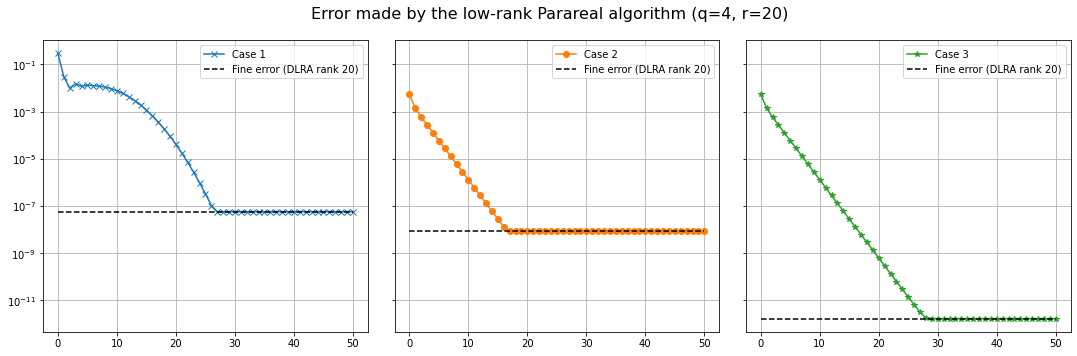

In [9]:
# PLOT THE ERROR MADE BY THE PARAREAL ALGORITHM
it = np.arange(0, nb_parareal_iter+1)
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
plt.suptitle('Error made by the low-rank Parareal algorithm (q=4, r=20)', fontsize=16)
plt.tight_layout()
# SUBPLOT 1
E1nk = LRP1.compute_parareal_error()
err1 = np.max(E1nk, axis=0)
ax[0].semilogy(it, err1, '-x', color='#1f77b4', label='Case 1')
ax[0].semilogy(it, np.max(LRP1.compute_fine_error())*np.ones(nb_parareal_iter+1), '--', color='black', label='Fine error (DLRA rank 20)')
ax[0].legend()
ax[0].grid()
# SUBPLOT 2
E2nk = LRP2.compute_parareal_error()
err2 = np.max(E2nk, axis=0)
ax[1].semilogy(it, err2, '-o', color='#ff7f0e', label='Case 2')
ax[1].semilogy(it, np.max(LRP2.compute_fine_error())*np.ones(nb_parareal_iter+1), '--', color='black', label='Fine error (DLRA rank 20)')
ax[1].legend()
ax[1].grid()
# SUBPLOT 3
E3nk = LRP3.compute_parareal_error()
err3 = np.max(E3nk, axis=0)
ax[2].semilogy(it, err3, '-*', color='#2ca02c', label='Case 3')
ax[2].semilogy(it, np.max(LRP3.compute_fine_error())*np.ones(nb_parareal_iter+1), '--', color='black', label='Fine error (DLRA rank 20)')
ax[2].legend()
ax[2].grid()

plt.show()
fig.savefig(f'figures/Lyapunov_heat/Size{n}/stagnation_low_rank_parareal_error.pdf')